## Approaches
After getting the data, I did some research about the 990 Form. I decide to do a mini-project studying the relations between the contribution and investment of organizations. There are many different approaches.
1. Study the contribution changing rate with investment changing rate over 1, 2, or 3 years
2. Study the contribution and investment in a specific year
3. Study the contribution and investment in a specific area (i.e. Madison WI)
4. Study the contribution and investment over different kinds of orgs
5. $\dots \dots$

## Steps
For this project, I would choose 2 over 2015 population. Following are the steps I am planning to take.
1. Fairly create a sample of orgs
    - With re-usable parameters(size, etc)
2. Get the interested entries for the orgs created above
    - With re-usable parameters(interested keys)
    - Write the result into a file, so it is easier for analyzing
3. Filter dirty data
    - Remove unhelpful data from the sample file
3. Analyze the data
    - Basis measuring statistics
    - Virtualization 
    - Explore relations of two keys

## Sampling
To be fair, I would use random sampling. Since the population size varies from year to year, I would use reservoir sampling algorithm.

In [31]:
import csv
import random
import xml.etree.ElementTree as ET
import requests

def sampling(size, f_name):
    """
    Random sampling `size` samples using the f_name csv file as population. 
    Reservoir sampling algorithm is used.

    Args:
        size(int) : sample size
        f_name(string) : name of the population file

    Returns:
        int list : samples, each element is the unique identifier of the filing
    """
    samples = []
    counter = 0
    with open(f_name, 'r') as fp:
        first_line = fp.readline()
        for line in fp:
            counter += 1
            # Fill in the samples 
            if len(samples) < size:
                samples.append(line.strip('\n')[-18:])
            # Dynamic probability of replacing samples with the new sample
            else:
                indicator = int(random.random() * counter)
                # With size/counter probability
                if indicator < size:
                    samples[indicator] = line.strip('\n')[-18:]
    return samples

## Fetching data
Once we have the organization samples, we can access the database to get the values we are interested. To make the function reusable, I would use a flexible approach, instead of hard code.

The flow is 
1. Use the unique identifier to locate the 990 form
2. Parse the xml file
3. Fetch the values with interested tags
4. Organize and create local csv file

In [32]:

def get_data(samples, output, *interests):
    """
    Accessing each sample, organize and write the interested entires.

    Args:
        samples(str list) : list of unique identifiers of the samples
        output(str) : file name of the output
        *interests : multiple string of the tags of interested entries. If the
            tags are not in the 990 form, values will be replaced with empty string

    """
    
    with open(output, 'w') as out_csv:
        # The headers are the identifier and interested tags
        writer = csv.DictWriter(out_csv, fieldnames = ['id'] + list(interests), 
                                delimiter = '\t')
        writer.writeheader()

        url_p = 'https://s3.amazonaws.com/irs-form-990/'
        url_e = '_public.xml'
        
        # Use counter to track the task rate
        counter = 0
        total = float(len(samples))

        for sample in samples:
            counter += 1
            print("Finished " + str(counter / total * 100) + "%")
            # Parse the xml file
            xml_response = requests.get(url_p + sample + url_e)
            root = ET.fromstring(xml_response.content)

            # Get the data for interested tags
            data = {'id' : sample}

            for tag in interests:
                # For missing data, we use empty string as replacement
                try:
                    data[tag] = next(root.iter('{http://www.irs.gov/efile}' + 
                                               tag)).text
                except StopIteration:
                    data[tag] = ''

            writer.writerow(data)

Now we can write a script to do the real operations. 

I choose the sample size to be 30000, and interested keys are all keys related to contribution and investment. 

This script has run for hours, so I used `ssh` and `screen` to execute it on the computers in the CS lab.

In [33]:
import sample

curr_sample = sample.sampling(30000, 'index_2015.csv')
sample.get_data(curr_sample, 'sample_2015.csv', 
                'PYContributionsGrantsAmt', 
                'CYContributionsGrantsAmt', 
                'TotalContributionsAmt', 
                'ContributionsGiftsGrantsEtcAmt',
                'PYInvestmentIncomeAmt', 
                'CYInvestmentIncomeAmt')

Finished 100.0%


The result is shown below.

In [6]:
with open('sample_2015.csv', 'r') as fp:
    length = 0
    for line in fp:
        print(line)
        length += 1
print(length)

id	PYContributionsGrantsAmt	CYContributionsGrantsAmt	TotalContributionsAmt	ContributionsGiftsGrantsEtcAmt	PYInvestmentIncomeAmt	CYInvestmentIncomeAmt

201542249349300954	344438	68709	68709		385	435

201510659349200201				4910		

201521699349200427				310		

201530429349200853				4903		

201531349349305353	38335	49927	49927		0	0

201542399349300724	603535	348126	348126		0	9842

201530629349100408						

201502529349100310						

201502239349301460	137017	210906	210906		0	0

201511359349101536						

201502309349200960						

201542029349300824		989148	989148			131

201502439349300735	372522	441452	441452		98	-3174

201531209349101023			240000			

201520159349100102						

201500729349300330	3886855	4286945	4286945		104638	121881

201542169349100604						

201522369349300207	432619	594609	594609		0	0

201531349349202693				33345		

201501349349305660	418960	44427	44427		391823	307090

201522369349300307	277082	722789	722789		43051	59512

201541769349100314						

201542109349200239				51

In [7]:
print(length)

28259


## Format the data
It ends the process of building a sample. Now I want to focus on the `PYContributionsGrantsAmt` and  `PYInvestmentIncomeAmt` two entries. I want to see whether there are some relations between of them.

Although we have 28259 neat and clean entries with the key which we may be interested in, many of them do not have `PYContributionsGrantsAmt` and `PYInvestmentIncomeAmt`. To make reading csv easier, we need to erase the unvalid data from the sample file.

In [8]:
with open('sample_2015.csv', 'r') as fp:
    with open('interest.csv', 'w') as out_fp:
        # Header line
        out_fp.write(fp.readline())
        for line in fp:
            entries = line.split('\t')
            
            # We only want the data with  valid PYContributionsGrantsAmt 
            # and PYInvestmentIncomeAmt
            if entries[1] and entries[1] != "RESTRICTED" and \
            entries[5] and entries[5] != "RESTRICTED":
                out_fp.write(line)

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Constants for the key
CONTRI = "PYContributionsGrantsAmt"
INVEST = "PYInvestmentIncomeAmt"

# Build data frame for analysis, from_csv() reader would maek some errors while parsing
df = pd.DataFrame.from_csv('interest.csv', sep = '\t')

                    PYContributionsGrantsAmt  CYContributionsGrantsAmt  \
id                                                                       
201542249349300954                    344438                     68709   
201531349349305353                     38335                     49927   
201542399349300724                    603535                    348126   
201502239349301460                    137017                    210906   
201502439349300735                    372522                    441452   
201500729349300330                   3886855                   4286945   
201522369349300207                    432619                    594609   
201501349349305660                    418960                     44427   
201522369349300307                    277082                    722789   
201541359349309199                   6017511                   6118975   
201521599349300852                    294874                    254497   
201531359349306593                    

## Analyzing the data
After getting the 11747 entries from the valid data, we can start our analysis. 
1. Basis measuring statistics
2. Virtualization 
3. Explore relations of two keys

In [11]:
print(df[CONTRI].mean())
print(df[CONTRI].median())
print(df[CONTRI].std())

2142237.82617
18194432.1808
173226.0


In [10]:
print(df[INVEST].mean())
print(df[INVEST].median())
print(df[INVEST].std())

359683.324849
3618067.79855


The standard deviation is so large that the mean is not accurate. Two medians can give us a big picture of two data. Next we can draw the box plot to further illustrate the measures.

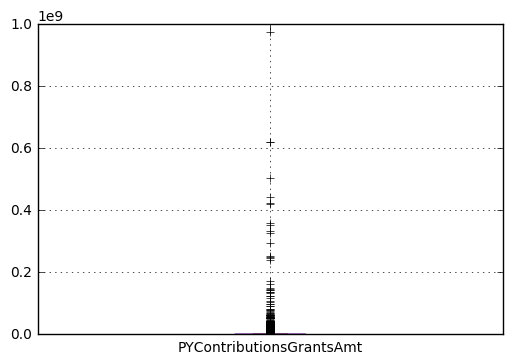

In [16]:
%matplotlib inline
df.boxplot(CONTRI)

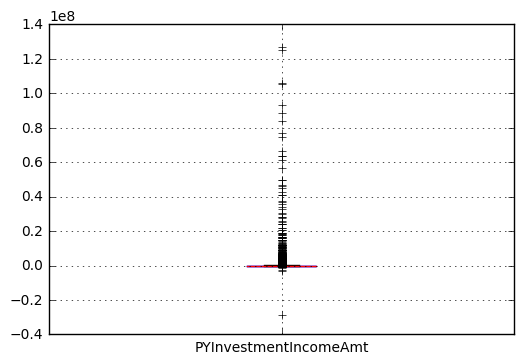

In [17]:
df.boxplot(INVEST)

The boxplots show that both data are highly skewed, and there are some outliers.

(0, 10000000)

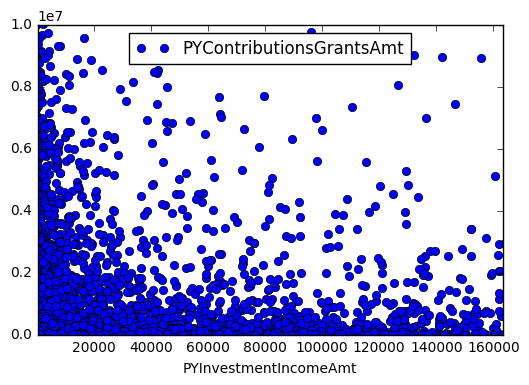

In [34]:
sca = df.plot(x=INVEST, y=CONTRI, style='o')
sca.set_ylim(0,10000000)

Many organize have a small (converges to $0$) investment but a significant contribution. We need to further understand the data before doing other analysis and operations.

From the right part of the plot, we cannot see there exists a clear linear relation between investment and contribution. 

## Conclusion
It is very fun to do a real-world data analyzing. I have learned A LOT, including xml parsing, pandas data analyzing, from this mini project.

The result is not quite as what I expected. If I have more time, or I would redo this project, I would definitely:

1. Do more research on the 990 Form, and come up with more helpful key entries to use.
2. Try to clustering the population. Using random sampling is not very fair in this project. I would try to divide the organizations into different groups, and perform the analysis in and within those groups.
3. Check the result of pandas csv reading result, it seems there are some wrongly-formated entries.
4. Explore more about the relations between contribution and investment.
3. Except the contribution and investment, I am also interested in some other cool studies. For example, how LGBTQ organizations develop in the United States from 2010.
